In [45]:
import pandas as pd
import seaborn as sns

import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import r2_score

from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.graphics.tsaplots import plot_pacf

from datetime import datetime

import meteostat

from enum import Enum

g_figsize = (20,15)

class MeteostatInterval(Enum):
    HOURLY = 1
    DAILY = 2
    MONTHLY = 3
    YEARLY = 4


# get the weather data from map coordinates using the meteostat weather python api
# https://dev.meteostat.net/python/#installation
def get_weather_data(longitude, latitude, elevation, start_time, end_time, value_names=['tavg', 'tmin', 'tmax'], intervals = MeteostatInterval.DAILY):
    # Set time period
    # Create Point for Vancouver, BC
    location_coords = meteostat.Point(longitude, latitude, elevation)

    # Get daily data for 2018
    if intervals == MeteostatInterval.DAILY :
        data = meteostat.Daily(location_coords, start_time, end_time)
    elif intervals == MeteostatInterval.HOURLY :
        data = meteostat.Hourly(location_coords, start_time, end_time)
    elif intervals == MeteostatInterval.MONTHLY :
        data = meteostat.Monthly(location_coords, start_time, end_time)
    elif intervals == MeteostatInterval.YEARLY :
        data = meteostat.Yearly(location_coords, start_time, end_time)
    
    data = data.fetch()

    # Drop all columns except for the one mentioned in the parameter value_names
    data.drop(labels = data.columns.difference(value_names), axis = 1, inplace=True)
    
    return data


# Plot the data
def plot_data(df, title='Remaining Passenger Number after modelling Trend and Seasonality', filename = None):
    '''
    Custom plotting function for plotting the flights dataset
    
    Parameters
    ----------
    df : pd.DataFrame
        The data to plot.
    title : str
        The title of the plot
    ylim : bool
        Whether to fix the minimum value of y; defalut is True
    
    Returns
    -------
    Plots the data
    '''
    df.plot(figsize=g_figsize)
    plt.title(title)
    plt.ylabel('# of Passengers in 1000')
    if filename is not None:
        plt.savefig(f'{filename}.svg')
    plt.show()
    

def get_temperature_df(file_path):
    

    df = pd.read_csv(file_path, sep=",", header = 14)

    temp_df = pd.DataFrame(columns={'date', 'mean_temperature'})

    temp_df['date'] = df['    DATE']
    temp_df['mean_temperature'] = df['   TG']/10.0

    temp_df['date'] = temp_df['date'].astype(str)

    def to_date_format(x):
        final_date = x[:4] + "-" + x[4:6] + "-" + x[6:8]
        return final_date
        

    temp_df['date'] = temp_df['date'].apply(to_date_format)
    temp_df['date'] = pd.to_datetime(temp_df['date'])

    temp_df.set_index('date', inplace=True)

    return temp_df


def get_previous_year_temp(date , years_duration, df):
    return df.loc[pd.to_datetime(date + years_duration * pd.Timedelta(days=365))]

def get_mean_temperature(date, years, df):
    temp_mean = 0

    for year in range(1, years + 1):
        temp_mean += get_previous_year_temp(date, year, df)
        temp_mean += get_previous_year_temp(date, -year, df)
        
    return temp_mean/(2 * years)

def impute_range_mean(df_limit, missing_value, years):

    missing_dates = pd.Series(df_limit.loc[df_limit['mean_temperature'] < missing_value].index.values)
    missing_temperatures = missing_dates.apply(get_mean_temperature, args=(years,df_limit))

    df_limit_copy = df_limit.copy()
    df_limit_copy.loc[df_limit['mean_temperature'] < missing_value] = missing_temperatures.values

    return df_limit_copy


def plot_resampled_temperatures(df, interval_type = 'Y', xaxis_labels_freq = None):

    if interval_type == 'D':
        df_resampled = df
        y = df_resampled['mean_temperature'].values
        temperature_column_label = 'mean_temperature'
    else :

        # For interval types Year and Month discard the means of Intervals which are partial
        # for example in this case as 2021 year is partial its mean will be discarded.
        # discarding partial bins taken from 
        # https://stackoverflow.com/questions/50272670/pandas-0-22-resample-only-full-bins-drop-partials
        df_resampled = df.resample(interval_type).agg({'mean_temperature':['mean','count']})
        df_resampled.columns = df_resampled.columns.map('_'.join)

        if(interval_type == 'Y'):
            df_resampled = df_resampled.query('mean_temperature_count == 365')
        if(interval_type == 'M'):
            df_resampled = df_resampled.query('mean_temperature_count == 30 or mean_temperature_count == 31 or mean_temperature_count == 28 or mean_temperature_count == 29')
        y = df_resampled['mean_temperature_mean'].values
        temperature_column_label = 'mean_temperature_mean'

    length = len(df_resampled)
    df_resampled = df_resampled.assign(timestep=list(range(length)))

    X = df_resampled['timestep'].values
    X = sm.add_constant(X)

    model = sm.OLS(y,X)
    results = model.fit()

    slopes = np.full((len(X),2), [results.params[0], results.params[1]])
    y_plot = np.sum(X*slopes, axis=1)

    fig, ax = plt.subplots(figsize=g_figsize)

    if xaxis_labels_freq is not None :
        # taken from 
        # https://www.earthdatascience.org/courses/scientists-guide-to-plotting-data-in-python/plot-with-matplotlib/introduction-to-matplotlib-plots/plot-time-series-data-in-python/
        ax.xaxis.set_major_locator(xaxis_labels_freq)
    # sns.lineplot(data=df_resampled, y=temperature_column_label, x='date', ax=ax)
    sns.lineplot(data=df_resampled, y=temperature_column_label, x=df_resampled.index, ax=ax)
    sns.lineplot(y=y_plot, x=df_resampled.index, ax=ax)



In [47]:

# Use this when data is extracted from https://www.ecad.eu/dailydata/index.php csv files
# temp_df = get_temperature_df("data/BerlinTempelhofMeanTemperature/TG_STAID002759.txt")
# temp_df.loc[temp_df['mean_temperature'] < -998]
# temp_df = impute_range_mean(temp_df, -998, 3)
# temp_df.loc['1945-04-25':'1945-11-05']


# Interlaken town map coordinates 46.686348, 7.863205, 576
# derived from https://www.maps.ie/coordinates.html
temp_df = get_weather_data(46.686348, 7.863205, 576, datetime(1980, 1, 1), datetime(2022, 1, 31), ['tavg'])
# getting the dates which have no mean temperature
# is_NaN = temp_df.isnull()
# row_has_NaN = is_NaN.any(axis=1)
# rows_with_NaN = temp_df[row_has_NaN]
# rows_with_NaN

# fill it with previous values
temp_df.fillna(method = 'pad', inplace=True)



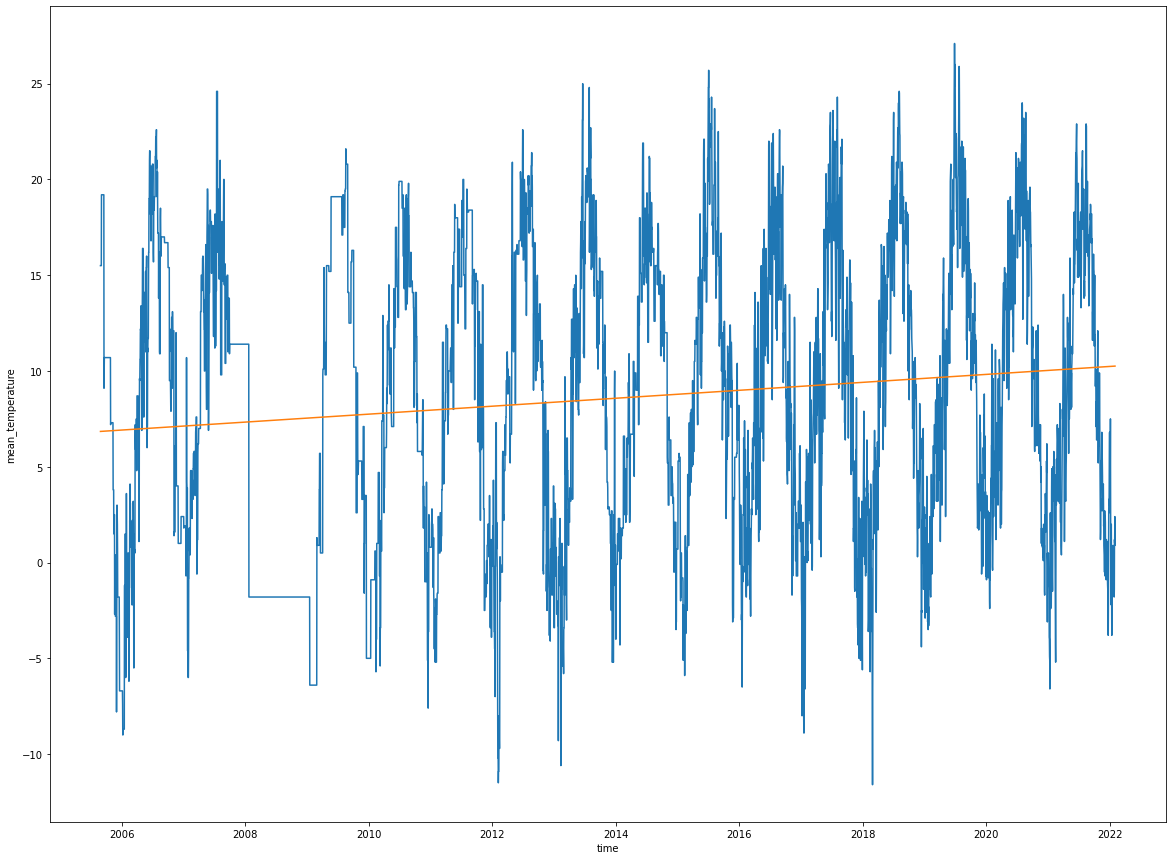

In [48]:

temp_df.rename(columns={'tavg':'mean_temperature'}, inplace=True)
plot_resampled_temperatures(temp_df, 'D')


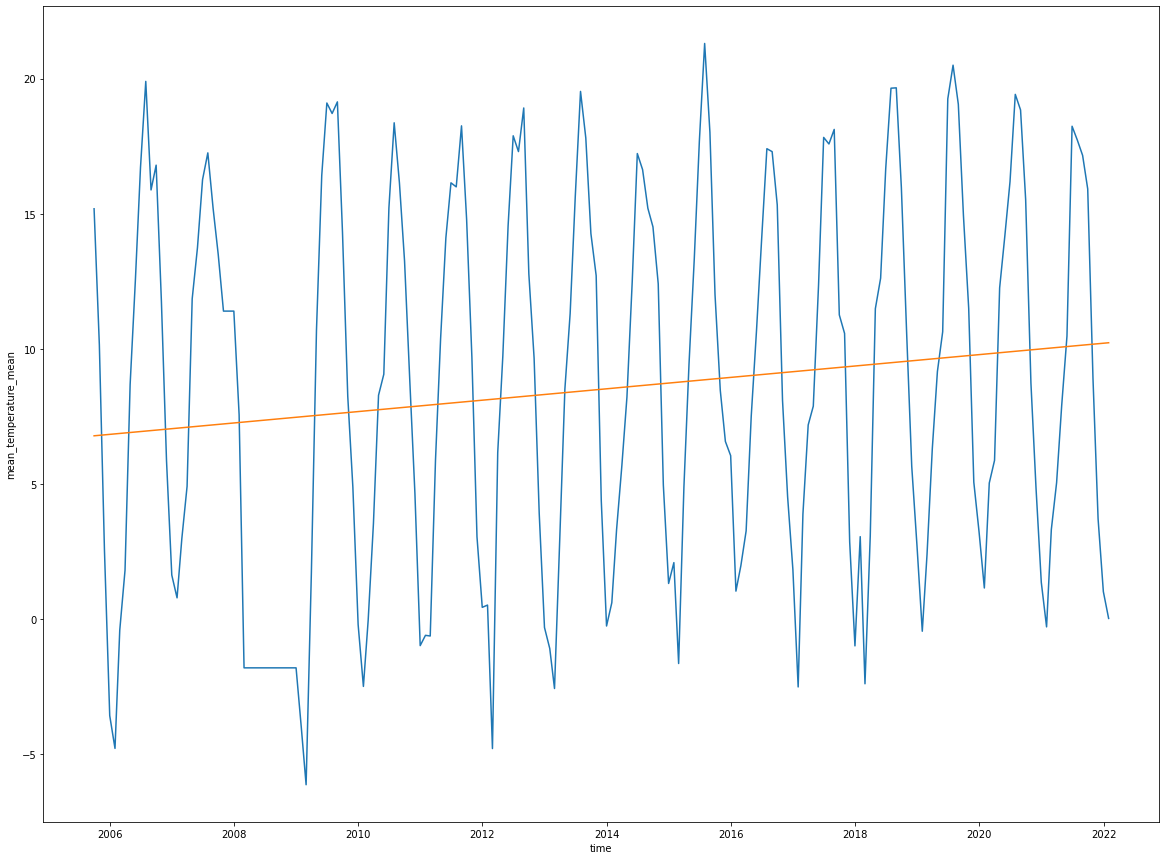

In [49]:
plot_resampled_temperatures(temp_df, 'M')

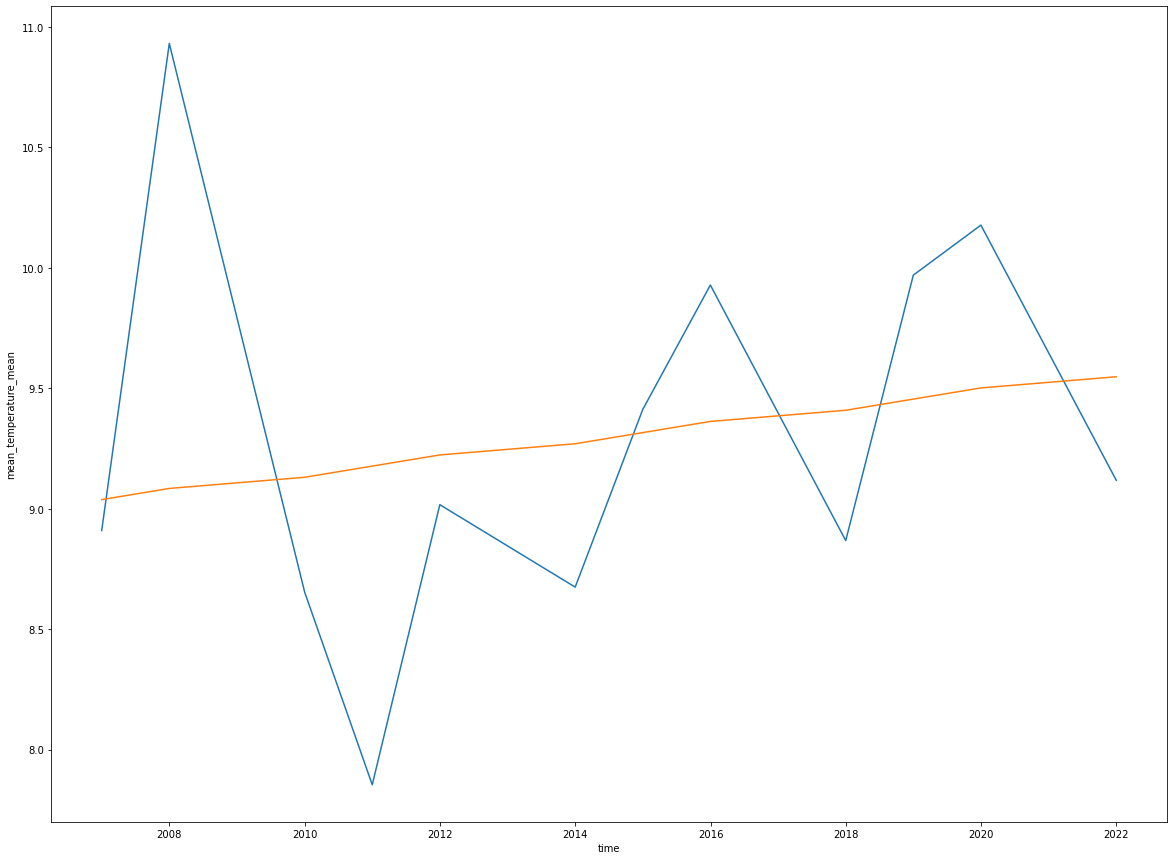

In [50]:

plot_resampled_temperatures(temp_df)

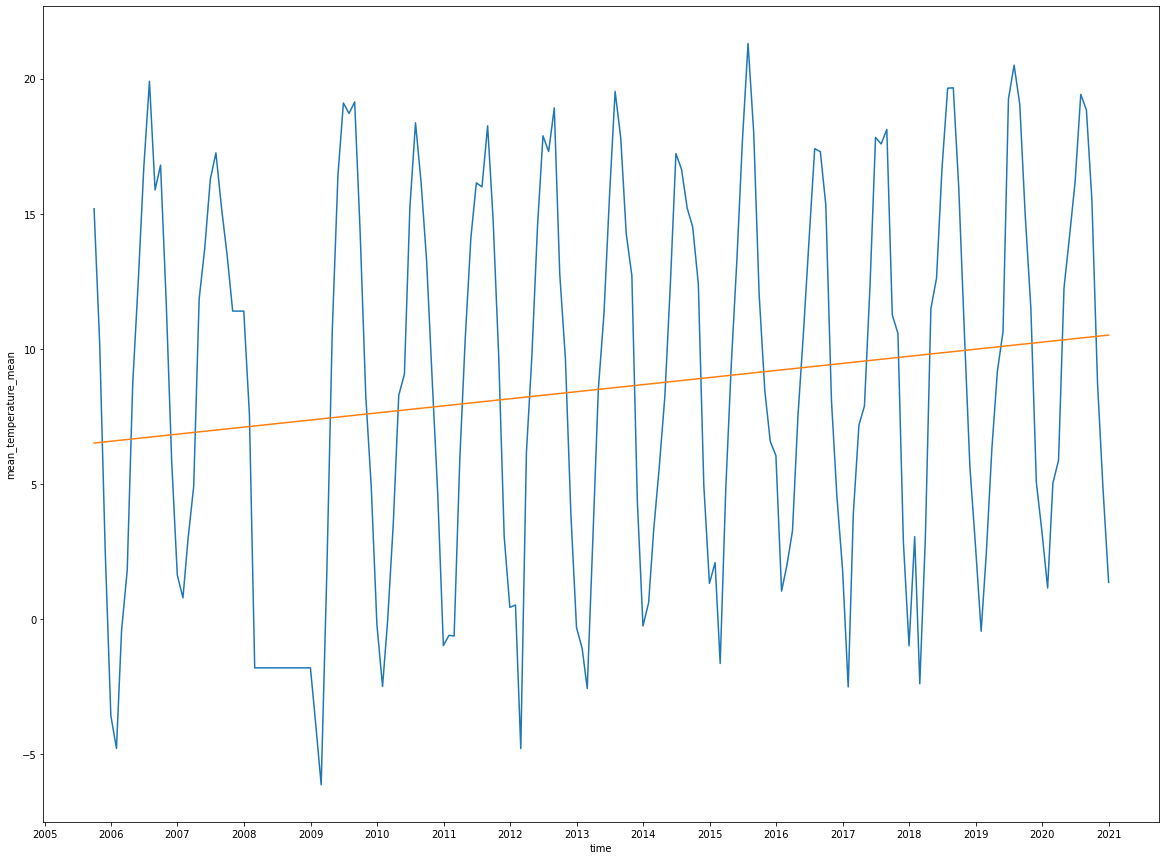

In [51]:
temp_five_years_df = temp_df.loc['2000-01-01':'2020-12-31']

plot_resampled_temperatures(temp_five_years_df, 'M', mdates.YearLocator())

In [52]:
temp_df['timestep'] = list(range(len(temp_df)))
m = LinearRegression()
X = temp_df[['timestep']]
y = temp_df['mean_temperature']

m.fit(X, y)

temp_df['trend'] = m.predict(X)

temp_df.head()




,mean_temperature,timestep,trend
time,,,
2005-08-28,15.5,0,6.845596
2005-08-29,15.5,1,6.846165
2005-08-30,15.5,2,6.846733
2005-08-31,15.5,3,6.847301
2005-09-01,15.5,4,6.847870


In [53]:

seasonal_dummies = pd.get_dummies(temp_df.index.month,
                                  prefix='month',
                                  drop_first=True).set_index(temp_df.index)

temp_df = temp_df.join(seasonal_dummies)

temp_df.head(60)



,mean_temperature,timestep,trend,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
time,,,,,,,,,,,,,,
2005-08-28,15.5,0,6.845596,0,0,0,0,0,0,1,0,0,0,0
2005-08-29,15.5,1,6.846165,0,0,0,0,0,0,1,0,0,0,0
2005-08-30,15.5,2,6.846733,0,0,0,0,0,0,1,0,0,0,0
2005-08-31,15.5,3,6.847301,0,0,0,0,0,0,1,0,0,0,0
2005-09-01,15.5,4,6.847870,0,0,0,0,0,0,0,1,0,0,0
2005-09-02,15.5,5,6.848438,0,0,0,0,0,0,0,1,0,0,0
2005-09-03,19.2,6,6.849006,0,0,0,0,0,0,0,1,0,0,0
2005-09-04,19.2,7,6.849575,0,0,0,0,0,0,0,1,0,0,0
2005-09-05,19.2,8,6.850143,0,0,0,0,0,0,0,1,0,0,0


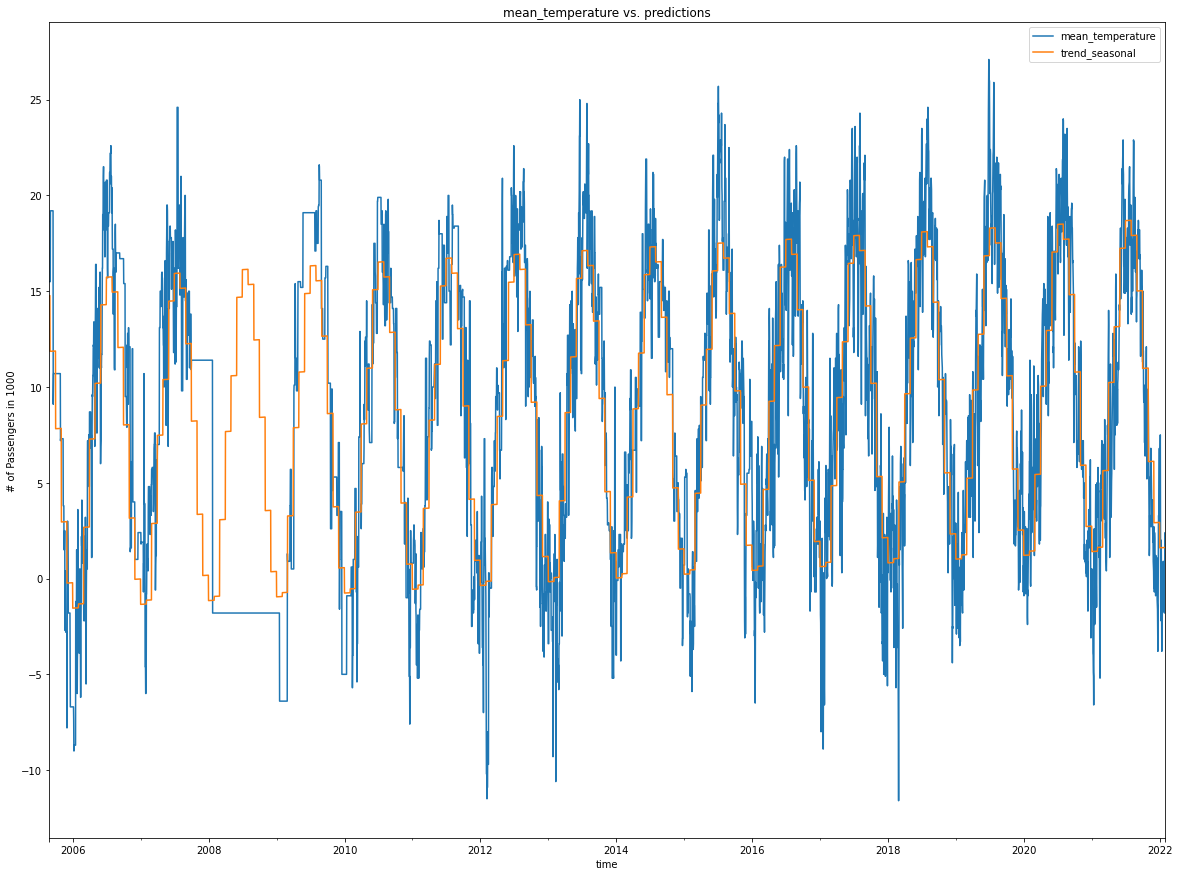

In [54]:

X_temp = temp_df.drop(columns=['mean_temperature'])
y_temp = temp_df.mean_temperature

m_temp = LinearRegression()
m_temp.fit(X_temp, y_temp)

temp_df['trend_seasonal'] = m_temp.predict(X_temp)

plot_data(temp_df[['mean_temperature', 'trend_seasonal']], title='mean_temperature vs. predictions')


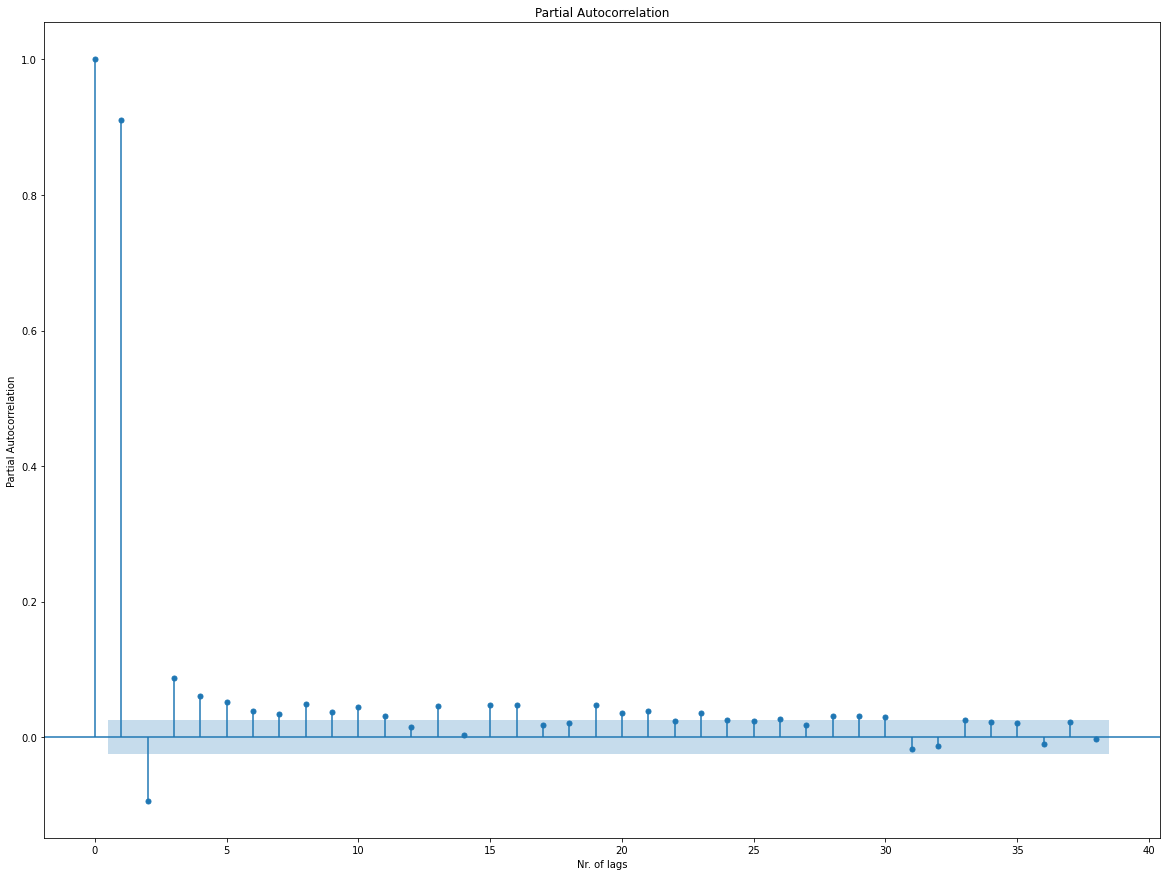

In [55]:
temp_df['remainder'] = temp_df['mean_temperature'] - temp_df['trend_seasonal']

with plt.rc_context():
    plt.rc("figure", figsize=g_figsize)
    plot_pacf(temp_df['remainder'])
    plt.xlabel('Nr. of lags')
    plt.ylabel('Partial Autocorrelation')

In [56]:
selected_order = ar_select_order(temp_df['remainder'], maxlag=20)
selected_order.ar_lags # tells us to use 4 lag




array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [57]:
# add lags
for lag in selected_order.ar_lags:
    temp_df[f'lag{lag}'] = temp_df['remainder'].shift(lag)

temp_df.dropna(inplace=True)

X_linear = temp_df.drop(columns=['mean_temperature', 'trend_seasonal', 'remainder', 'timestep'])
y_linear = temp_df.mean_temperature

m_linear = LinearRegression()
m_linear.fit(X_linear, y_linear)

LinearRegression()

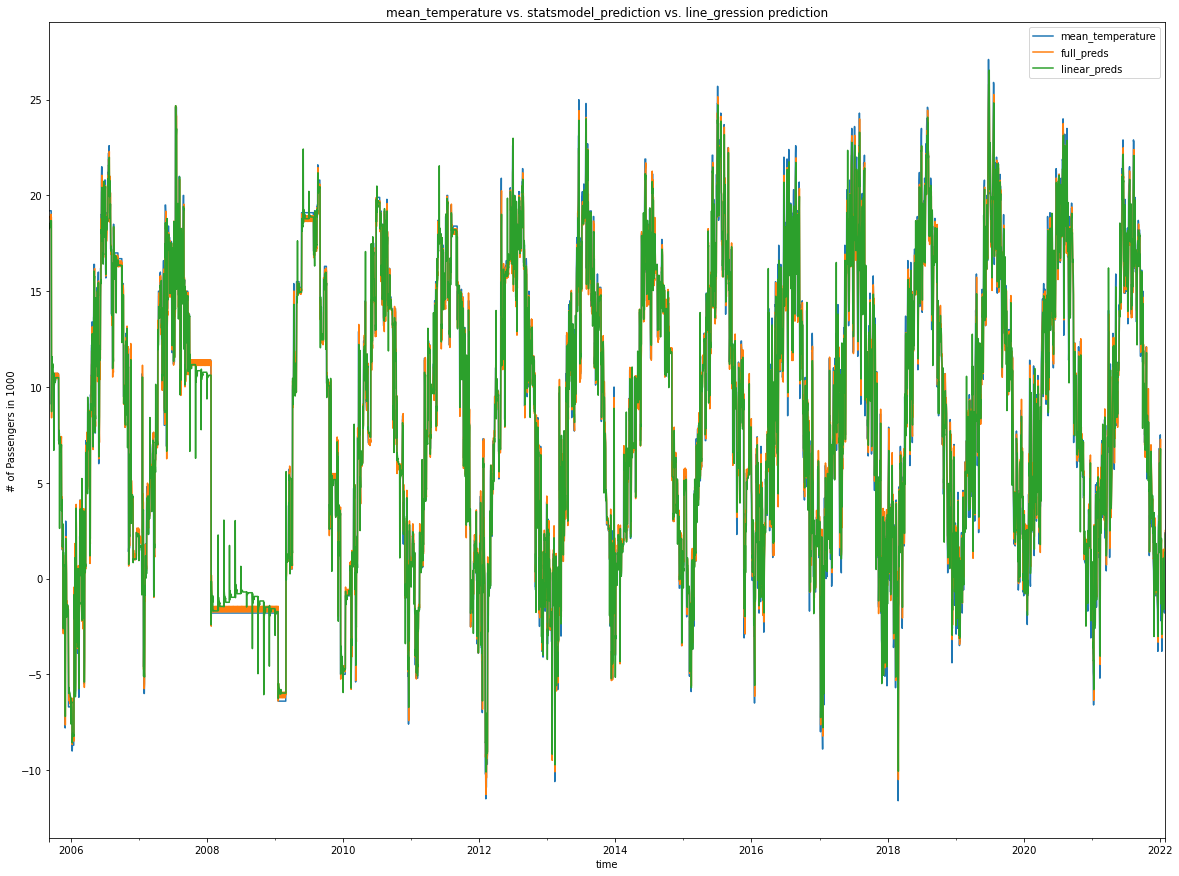

In [58]:

statsmodels_ar = AutoReg(temp_df['mean_temperature'], lags=4, trend='ct', seasonal=True).fit()

# plt.plot(statsmodels_ar.predict())
# plt.plot(temp_df['mean_temperature'])

temp_df['full_preds'] = statsmodels_ar.predict()
temp_df['linear_preds'] = m_linear.predict(X_linear)
plot_data(temp_df[['mean_temperature', 'full_preds', 'linear_preds']], title='mean_temperature vs. statsmodel_prediction vs. line_gression prediction')




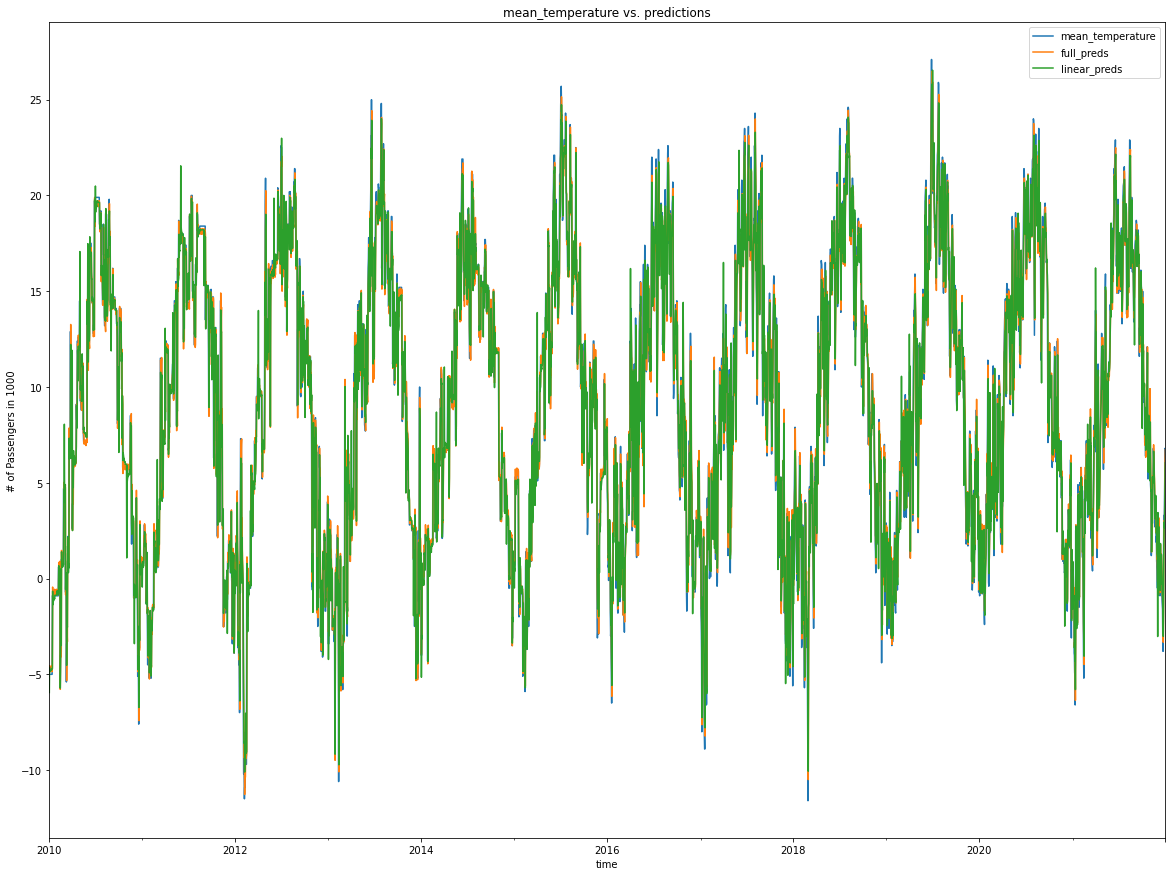

In [59]:

temp_df_limit = temp_df.loc['2010-01-01':'2021-12-31']
plot_data(temp_df_limit[['mean_temperature', 'full_preds', 'linear_preds']], title='mean_temperature vs. predictions')

In [60]:
X = temp_df.drop(['mean_temperature', 'trend_seasonal', 'remainder', 'timestep', 'full_preds', 'linear_preds'], axis=1)


X.columns


Index(['trend', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12',
       'lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9',
       'lag10'],
      dtype='object')

In [61]:

y = temp_df['mean_temperature']


ts_split = TimeSeriesSplit(n_splits=5) # instanciate the class and give the k as input

time_cv = ts_split.split(X, y) # this is a python generator


estimator = LinearRegression()

r_squared_scores = cross_val_score(estimator=estimator, X=X, y=y, cv=time_cv )

print(r_squared_scores)
print(r_squared_scores.mean())

[0.97030581 0.92941802 0.91576233 0.91907655 0.94390929]
0.9356943980131082
